## Review of homework
___

## Regularizers

The function of regularizers is to improve generalization.  
They create restrictions on the values that weights can take, and reduce the search space that the optimizer explores.  
As such, regularizers **decrease model capacity**. This is the reason for their capacity to reduce overfitting.

Let's look at five common regularization techniques, why we use them, and how they help prevent overfitting.

___
### New framework
*Why are we changing the weights*: Belief  
*What does it change*: Prior  
*How do we change it*: Practical modification  

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as vF
import numpy as np
import torchvision
import os
from pathlib import Path
import glob
import PIL.Image as Image

In [4]:
class Dataset_MNIST(torch.utils.data.Dataset):
    def __init__(self, root, classes, mode="train", transform=None, balance=[0.7,0.15,0.15], each_data_num=10000000):
        
        self.transform = transform
        self.images = []
        self.labels = []

        images = {} 
        labels = {}
        
        for cl in classes:
            path_list = glob.glob(root + f"{cl}/*")
            path_list.sort()
            path_list = path_list[:each_data_num]
            train_num = int(balance[0]*len(path_list))
            val_num = int(balance[1]*len(path_list))
            test_num = int(balance[2]*len(path_list))
            if mode=="train":
                path_list = path_list[:train_num]
            elif mode=="val":
                path_list = path_list[train_num:train_num+val_num]
            elif mode=="test":
                path_list = path_list[-test_num:]
            images[str(cl)] = path_list
            labels[str(cl)] = [cl]*len(path_list)
            
        # combine them together
        for label in classes:
            for image, label in zip(images[str(label)], labels[str(label)]):
                self.images.append(image)
                self.labels.append(label)

    def __getitem__(self, index):
        
        image = self.images[index]
        label = self.labels[index]
        
        with open(image, 'rb') as f:
            image = Image.open(f)
            image = image.convert("L")
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    def __len__(self):
        return len(self.images)

In [5]:
MAX_EPOCH = 100
LR = 0.01
TRIALS = 10

In [6]:
class BasicModel(nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()
        self.c1 = nn.Conv2d(1, 9, (3,3), padding=(1,1))
        self.p1 = nn.MaxPool2d(2, stride=2)
        self.c2 = nn.Conv2d(9, 16, (3,3), padding=(1,1))
        self.p2 = nn.MaxPool2d(2, stride=2)
        self.l1 = nn.Linear(7*7*16, 32)
        self.l2 = nn.Linear(32, 10)
        
    def forward(self, x):
        h = F.relu(self.c1(x))
        h = self.p1(h)
        h = F.relu(self.c2(h))
        h = self.p2(h)
        h = h.view(-1, 7*7*16)
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        y = F.softmax(h, dim=1)
        return y

In [7]:
dataset_train = Dataset_MNIST('./smalldataset/', mode='train', classes=[5,6,8], transform=torchvision.transforms.ToTensor(), balance=[0.8,0,0.2])
dataset_test = Dataset_MNIST('./smalldataset/', mode='test', classes=[5,6,8], transform=torchvision.transforms.ToTensor(), balance=[0.8,0,0.2])
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True)

In [8]:
def calc_train_acc():
    c = 0 
    w = 0
    for x, y in dataset_train:
        if model(x[None,...].cuda()).argmax()==y:
            c += 1
        else:
            w -= -1
#     print('Train accuracy: {}'.format(c/(c+w)))
    return c/(c+w)

In [9]:
def calc_test_acc():
    c = 0 
    w = 0
    for x, y in dataset_test:
        if model(x[None,...].cuda()).argmax()==y:
            c += 1
        else:
            w -= -1
#     print('Test accuracy: {}'.format(c/(c+w)))
    return c/(c+w)

In [31]:
losses = []
train_acc = []
test_acc = []
for trial in range(TRIALS):
    criterion = nn.CrossEntropyLoss().cuda()
    model = BasicModel().cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.999**epoch)
    
    weights = []
    for child in model.children():
        try:
            weights.append(child.weight)
            weights.append(child.bias)
        except:
            pass
    
    best_loss = 1000
    for epoch in range(MAX_EPOCH):
        for x, y in dataloader_train:
    #         zero buffers
            optimizer.zero_grad() 
    #         forward propagation
            prediction = model(x.cuda())

            loss = criterion(prediction, y.cuda())+sum([torch.abs(w).sum() for w in weights])*0.001

    #         gradient calculation
            loss.backward()
    #         parameter update
            optimizer.step() 

        print('Trial: {}, Epoch: {}, Loss: {}'.format(trial, epoch, loss), end='\r')
        scheduler.step()
        
        if loss<best_loss:
            best_loss = loss
            
    losses.append(loss)
    train_acc.append(calc_train_acc())
    test_acc.append(calc_test_acc())
    print()
        

Trial: 0, Epoch: 99, Loss: 1.6925469636917114
Trial: 1, Epoch: 99, Loss: 1.5728302001953125
Trial: 2, Epoch: 99, Loss: 1.9711151123046875
Trial: 3, Epoch: 99, Loss: 2.3736147880554286
Trial: 4, Epoch: 99, Loss: 2.3235127925872803
Trial: 5, Epoch: 99, Loss: 1.7843334674835205
Trial: 6, Epoch: 99, Loss: 2.2456319332122803
Trial: 7, Epoch: 99, Loss: 2.3176929950714118
Trial: 8, Epoch: 99, Loss: 1.7755613327026367
Trial: 9, Epoch: 99, Loss: 1.8830586671829224


In [32]:
print('Mean Loss: {:.4}, Mean Train Acc: {:.4}, Mean Test Acc: {:.4}'.format(
                                                        sum(losses)/TRIALS,
                                                        sum(train_acc)/TRIALS,
                                                        sum(test_acc)/TRIALS,
                                                        ))

Mean Loss: 1.994, Mean Train Acc: 0.5639, Mean Test Acc: 0.5111


___
## L1 regularizer

*Why*: weights should be sparse  
*What*: pull less important weights towards 0  
*How*: L1 penalty to the weights (sum of absolute weights)  

In [43]:
losses = []
train_acc = []
test_acc = []
for trial in range(TRIALS):
    criterion = nn.CrossEntropyLoss().cuda()
    model = BasicModel().cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.999**epoch)
    
    weights = []
    for child in model.children():
        try:
            weights.append(child.weight)
            weights.append(child.bias)
        except:
            pass
    
    best_loss = 1000
    for epoch in range(MAX_EPOCH):
        for x, y in dataloader_train:
    #         zero buffers
            optimizer.zero_grad() 
    #         forward propagation
            prediction = model(x.cuda())

            ###########################################
            loss = criterion(prediction, y.cuda())+sum([torch.abs(w).sum() for w in weights])*0.001
            ###########################################

    #         gradient calculation
            loss.backward()
    #         parameter update
            optimizer.step() 

        print('Trial: {}, Epoch: {}, Loss: {}'.format(trial, epoch, loss), end='\r')
        scheduler.step()
        
        if loss<best_loss:
            best_loss = loss
            
    losses.append(loss)
    train_acc.append(calc_train_acc())
    test_acc.append(calc_test_acc())
    print()
        

Trial: 0, Epoch: 99, Loss: 2.0159039497375493
Trial: 1, Epoch: 99, Loss: 1.8974485397338867
Trial: 2, Epoch: 99, Loss: 1.5526751279830933
Trial: 3, Epoch: 99, Loss: 2.3704555034637452
Trial: 4, Epoch: 99, Loss: 1.9689602851867676
Trial: 5, Epoch: 99, Loss: 2.3221611976623535
Trial: 6, Epoch: 99, Loss: 1.6094920635223389
Trial: 7, Epoch: 99, Loss: 1.7936595678329468
Trial: 8, Epoch: 99, Loss: 1.7900675535202026
Trial: 9, Epoch: 99, Loss: 1.5746560096740723


In [44]:
print('Mean Loss: {:.4}, Mean Train Acc: {:.4}, Mean Test Acc: {:.4}'.format(
                                                        sum(losses)/TRIALS,
                                                        sum(train_acc)/TRIALS,
                                                        sum(test_acc)/TRIALS,
                                                        ))

Mean Loss: 1.89, Mean Train Acc: 0.6944, Mean Test Acc: 0.6167


___
## L2 regularizer

*Why*: weights should be smaller evenly  
*What*: pull all weights evenly towards the origin (0, 0, ..., 0)  
*How*: L2 penalty to the weights (sum of square weights)  

In [35]:
losses = []
train_acc = []
test_acc = []
for trial in range(TRIALS):
    criterion = nn.CrossEntropyLoss().cuda()
    model = BasicModel().cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.999**epoch)
    
    weights = []
    for child in model.children():
        try:
            weights.append(child.weight)
            weights.append(child.bias)
        except:
            pass
    
    best_loss = 1000
    for epoch in range(MAX_EPOCH):
        for x, y in dataloader_train:
    #         zero buffers
            optimizer.zero_grad() 
    #         forward propagation
            prediction = model(x.cuda())

            ###########################################
            loss = criterion(prediction, y.cuda())+sum([(w**2).sum() for w in weights])*0.01
            ###########################################

    #         gradient calculation
            loss.backward()
    #         parameter update
            optimizer.step() 

        print('Trial: {}, Epoch: {}, Loss: {}'.format(trial, epoch, loss), end='\r')
        scheduler.step()
        
        if loss<best_loss:
            best_loss = loss
            
    losses.append(loss)
    train_acc.append(calc_train_acc())
    test_acc.append(calc_test_acc())
    print()
        

Trial: 0, Epoch: 99, Loss: 2.3579778671264655
Trial: 1, Epoch: 99, Loss: 2.3097934722900398
Trial: 2, Epoch: 99, Loss: 1.8985996246337893
Trial: 3, Epoch: 99, Loss: 1.8908604383468628
Trial: 4, Epoch: 99, Loss: 1.5808395147323608
Trial: 5, Epoch: 99, Loss: 1.6338837146759033
Trial: 6, Epoch: 99, Loss: 1.5922881364822388
Trial: 7, Epoch: 99, Loss: 2.1117160320281982
Trial: 8, Epoch: 99, Loss: 2.2828524112701416
Trial: 9, Epoch: 99, Loss: 1.7834382057189941


In [36]:
print('Mean Loss: {:.4}, Mean Train Acc: {:.4}, Mean Test Acc: {:.4}'.format(
                                                        sum(losses)/TRIALS,
                                                        sum(train_acc)/TRIALS,
                                                        sum(test_acc)/TRIALS,
                                                        ))

Mean Loss: 1.944, Mean Train Acc: 0.6389, Mean Test Acc: 0.5889


___
## Early stopping:
*Why*: when the model starts overfitting, the training loss will continue to decrease but the validation loss will not  
*What*: reduce the probability of weights that act in this regime  
*How*: stop training when validation loss stops improving  

In [37]:
PATIENCE = 10

In [38]:
losses = []
train_acc = []
test_acc = []

for trial in range(TRIALS):
    criterion = nn.CrossEntropyLoss().cuda()
    model = BasicModel().cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.999**epoch)
    
    
    weights = []
    for child in model.children():
        try:
            weights.append(child.weight)
            weights.append(child.bias)
        except:
            pass
    
    best_loss = 1000
    for epoch in range(MAX_EPOCH):
        
        ###########################################
        no_improvement = 0
        best_loss = 1000
        ###########################################
    
        for x, y in dataloader_train:
    #         zero buffers
            optimizer.zero_grad() 
    #         forward propagation
            prediction = model(x.cuda())

            loss = criterion(prediction, y.cuda())

    #         gradient calculation
            loss.backward()
    #         parameter update
            optimizer.step() 
        
            if loss<best_loss:
                best_loss=loss
                no_improvement = 0
            else:
                no_improvement += 1
                if no_improvement>PATIENCE:
                    break

        print('Trial: {}, Epoch: {}, Loss: {}'.format(trial, epoch, loss), end='\r')
        scheduler.step()
        
        if loss<best_loss:
            best_loss = loss
            
    losses.append(loss)
    train_acc.append(calc_train_acc())
    test_acc.append(calc_test_acc())
    print()
        

Trial: 0, Epoch: 99, Loss: 1.4647108316421509
Trial: 1, Epoch: 99, Loss: 1.4616041183471683
Trial: 2, Epoch: 99, Loss: 2.0824708938598633
Trial: 3, Epoch: 99, Loss: 1.8164957761764526
Trial: 4, Epoch: 99, Loss: 1.8316044807434082
Trial: 5, Epoch: 99, Loss: 1.7113192081451416
Trial: 6, Epoch: 99, Loss: 1.5884190797805786
Trial: 7, Epoch: 99, Loss: 1.4613454341888428
Trial: 8, Epoch: 99, Loss: 1.4613285064697266
Trial: 9, Epoch: 99, Loss: 1.4629142284393314


In [39]:
print('Mean Loss: {:.4}, Mean Train Acc: {:.4}, Mean Test Acc: {:.4}'.format(
                                                        sum(losses)/TRIALS,
                                                        sum(train_acc)/TRIALS,
                                                        sum(test_acc)/TRIALS,
                                                        ))

Mean Loss: 1.634, Mean Train Acc: 0.7597, Mean Test Acc: 0.6722


___
## Dataset enhancement
*Why*: by increasing our dataset we can reduce overfitting, and there are easy ways to generate new training pairs from existing pairs  
*What*: reduce the probability of weights that perform badly in the specific ways for which we enhanced for  
*How*: by making making changes to existing examples in ways to which we believe the model should be invariant  

In [53]:
import copy
import matplotlib.pyplot as plt

In [52]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop((20,20)),
    torchvision.transforms.Pad((4,4)),
    torchvision.transforms.ToTensor()
])

In [55]:
dataset_train_enhanced = copy.copy(dataset_train)
dataset_train_enhanced.transform = new_transform
dataloader_train_enhanced = torch.utils.data.DataLoader(dataset_train_enhanced, batch_size=8, shuffle=True)

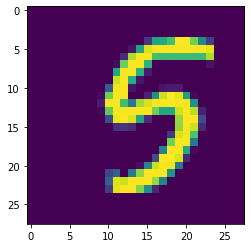

In [91]:
plt.imshow(dataset_train_enhanced[0][0].numpy()[0])

In [56]:
losses = []
train_acc = []
test_acc = []
for trial in range(TRIALS):
    criterion = nn.CrossEntropyLoss().cuda()
    model = BasicModel().cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.999**epoch)
    
    weights = []
    for child in model.children():
        try:
            weights.append(child.weight)
            weights.append(child.bias)
        except:
            pass
    
    best_loss = 1000
    for epoch in range(MAX_EPOCH):
        for x, y in dataloader_train_enhanced:
    #         zero buffers
            optimizer.zero_grad() 
    #         forward propagation
            prediction = model(x.cuda())

            loss = criterion(prediction, y.cuda())

    #         gradient calculation
            loss.backward()
    #         parameter update
            optimizer.step() 

        print('Trial: {}, Epoch: {}, Loss: {}'.format(trial, epoch, loss), end='\r')
        scheduler.step()
        
        if loss<best_loss:
            best_loss = loss
            
    losses.append(loss)
    train_acc.append(calc_train_acc())
    test_acc.append(calc_test_acc())
    print()
        

Trial: 0, Epoch: 99, Loss: 1.5213726758956914
Trial: 1, Epoch: 99, Loss: 2.3025853633880615
Trial: 2, Epoch: 99, Loss: 1.8438680171966553
Trial: 3, Epoch: 99, Loss: 1.7129114866256714
Trial: 4, Epoch: 99, Loss: 2.1256837844848633
Trial: 5, Epoch: 99, Loss: 1.7659256458282478
Trial: 6, Epoch: 99, Loss: 1.9604092836380005
Trial: 7, Epoch: 99, Loss: 1.9906835556030273
Trial: 8, Epoch: 99, Loss: 1.6827559471130375
Trial: 9, Epoch: 99, Loss: 2.0861489772796636


In [57]:
print('Mean Loss: {:.4}, Mean Train Acc: {:.4}, Mean Test Acc: {:.4}'.format(
                                                        sum(losses)/TRIALS,
                                                        sum(train_acc)/TRIALS,
                                                        sum(test_acc)/TRIALS,
                                                        ))

Mean Loss: 1.899, Mean Train Acc: 0.6403, Mean Test Acc: 0.6278


___
## Dropout
*Why*: machine learning methods generalize better if they have some redundancy (think bagging methods), always training together reduces the individual power of each weight  
*What*: Reduce the probability of weights that produce very inter-dependent neurons (increase the probability of independent feature extraction)
*How*: at each training step, prevent randomly selected weights from participating in any calculations (both forwards and backwards propagation)  
  
Disclaimer: We don't really understand why dropout works so well. 

In [40]:
class DropoutModel(nn.Module):
    def __init__(self):
        super(DropoutModel, self).__init__()
        self.c1 = nn.Conv2d(1, 9, (3,3), padding=(1,1))
        self.p1 = nn.MaxPool2d(2, stride=2)
        
        ###########################################
        self.dr1 = nn.Dropout2d(0.3)
        ###########################################
       
        self.c2 = nn.Conv2d(9, 16, (3,3), padding=(1,1))
        self.p2 = nn.MaxPool2d(2, stride=2)
         
        ###########################################
        self.dr2 = nn.Dropout2d(0.3)
        ###########################################
        
        self.l1 = nn.Linear(7*7*16, 32)
        self.l2 = nn.Linear(32, 10)
        
    def forward(self, x):
        h = F.relu(self.c1(x))
        
        ###########################################
        h = self.dr1(h)
        ###########################################
        
        h = self.p1(h)
        h = F.relu(self.c2(h))
        
        ###########################################
        h = self.dr2(h)
        ###########################################
        
        h = self.p2(h)
        h = h.view(-1, 7*7*16)
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        y = F.softmax(h, dim=1)
        return y

In [41]:
losses = []
train_acc = []
test_acc = []
for trial in range(TRIALS):
    criterion = nn.CrossEntropyLoss().cuda()
    model = DropoutModel().cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.999**epoch)
    
    weights = []
    for child in model.children():
        try:
            weights.append(child.weight)
            weights.append(child.bias)
        except:
            pass
    
    best_loss = 1000
    for epoch in range(MAX_EPOCH):
        for x, y in dataloader_train:
    #         zero buffers
            optimizer.zero_grad() 
    #         forward propagation
            prediction = model(x.cuda())

            loss = criterion(prediction, y.cuda())

    #         gradient calculation
            loss.backward()
    #         parameter update
            optimizer.step() 

        print('Trial: {}, Epoch: {}, Loss: {}'.format(trial, epoch, loss), end='\r')
        scheduler.step()
        
        if loss<best_loss:
            best_loss = loss
            
    losses.append(loss)
    train_acc.append(calc_train_acc())
    test_acc.append(calc_test_acc())
    print()
        

Trial: 0, Epoch: 99, Loss: 2.2110929489135744
Trial: 1, Epoch: 99, Loss: 1.9611510038375854
Trial: 2, Epoch: 99, Loss: 1.4865503311157227
Trial: 3, Epoch: 99, Loss: 1.8488260507583618
Trial: 4, Epoch: 99, Loss: 2.3026018142700195
Trial: 5, Epoch: 99, Loss: 1.4611811637878418
Trial: 6, Epoch: 99, Loss: 1.5831022262573242
Trial: 7, Epoch: 99, Loss: 2.2110857963562016
Trial: 8, Epoch: 99, Loss: 1.5928748846054077
Trial: 9, Epoch: 99, Loss: 1.6543922424316406


In [42]:
print('Mean Loss: {:.4}, Mean Train Acc: {:.4}, Mean Test Acc: {:.4}'.format(
                                                        sum(losses)/TRIALS,
                                                        sum(train_acc)/TRIALS,
                                                        sum(test_acc)/TRIALS,
                                                        ))

Mean Loss: 1.831, Mean Train Acc: 0.5806, Mean Test Acc: 0.5333
